<a href="https://colab.research.google.com/github/tfrizza/DALL-E-tf/blob/main/MNIST_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!git clone https://github.com/tfrizza/DALL-E-tf.git

Cloning into 'DALL-E-tf'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 28 (delta 12), reused 21 (delta 9), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [39]:
%cd DALL-E-tf

/content/DALL-E-tf


In [52]:
import tensorflow as tf
from tensorflow.keras import Model

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl

from dall_e_tf.encoder import dvae_encoder
from dall_e_tf.decoder import dvae_decoder
from dall_e_tf.utils import plot_reconstructions

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [83]:
vocab_size = 32
n_hid = 32

enc = dvae_encoder(group_count=2, n_hid=n_hid, n_blk_per_group=2, input_channels=x_train.shape[-1], vocab_size=vocab_size)
dec = dvae_decoder(group_count=2, n_init=n_hid//2, n_hid=n_hid, n_blk_per_group=2, output_channels=x_train.shape[-1], vocab_size=vocab_size)

def dVAE(enc, dec, temperature=1/16):
    z_e = enc.output # encoder logits

    z_q = tfpl.DistributionLambda(
        lambda logits: tfd.RelaxedOneHotCategorical(temperature, logits) # Gumbel-softmax
    )(z_e)

    z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
    z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=tf.float32)

    z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
    x_rec = dec(z)
    return Model(enc.input, x_rec)

vae = dVAE(enc, dec, 1)
vae.summary(line_length=200)

Model: "model_49"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_37 (InputLayer)                                             [(None, None, None, 1)]                     0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv2d_702 (Conv2D)                                               (None, None, None, 32)                      1600                    input_37[0][0]                              

In [84]:
vae.compile(loss='mse', optimizer='adam')

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        # steps_per_epoch=10,
        epochs=1,
        batch_size=32,
        shuffle=True)

1875/1875 [==============================] - 23s 11ms/step - loss: 0.0224 - val_loss: 0.0031


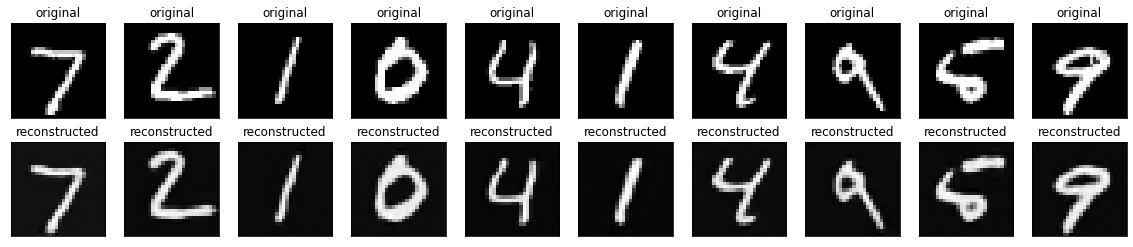

In [85]:
plot_reconstructions(vae, x_test[:10])